In [8]:
pip install playwright

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install nbconvert[webpdf]

   ---------------------------------------- 0.0/29.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/29.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/29.8 MB 667.8 kB/s eta 0:00:45
   ---------------------------------------- 0.1/29.8 MB 1.1 MB/s eta 0:00:27
   ---------------------------------------- 0.3/29.8 MB 2.5 MB/s eta 0:00:13
    --------------------------------------- 0.7/29.8 MB 4.4 MB/s eta 0:00:07
   - -------------------------------------- 1.3/29.8 MB 6.2 MB/s eta 0:00:05
   --- ------------------------------------ 2.7/29.8 MB 11.3 MB/s eta 0:00:03
   ------- -------------------------------- 5.7/29.8 MB 21.6 MB/s eta 0:00:02
   ------- -------------------------------- 5.7/29.8 MB 21.6 MB/s eta 0:00:02
   ------------ --------------------------- 9.1/29.8 MB 26.4 MB/s eta 0:00:01
   ------------------- -------------------- 14.5/29.8 MB 93.9 MB/s eta 0:00:01
   ------------------- -------------------- 14.8/29.8 MB 73.1 MB/s eta 0:00:01
   

In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
Импорты:

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from scipy import integrate
from sklearn.model_selection import train_test_split, KFold

In [2]:
Подготовка данных:

SyntaxError: invalid syntax (564263690.py, line 1)

In [16]:
#Перевод mat файлов в формат df
class MatFileProcessor:
    def __init__(self, folder_path):
        self.folder_path = folder_path
    
    def process_mat_file(self, tt):
    
        
        
        # Определяем все ключи, которые нам нужны из мат-файла
        
        
        keys = [ 'Total_system_power', 'outside_temperature', 'Month', 'LocalHourOffset', 'LocalMinuteOffset',
                 'Year', 'Day',  'Hours',  'Minutes', 'Seconds', 'B2V_SOC', 'B2V_TotalI', 'L_INV2TM_MotorSpeed','R_INV2TM_MotorSpeed','avg_B2V_SOC',
                 'avg_B2V_TotalI','avg_L_INV2TM_MotorSpeed','vehicle_range' ]
        
        # Создание DataFrame из матлаб массива
        df = pd.DataFrame(tt, columns=keys)
        # Округление данных до трех знаков после запятой
        df = df.round(4)
        
        # Удаление строк с пропущенными значениями
        df.dropna(inplace=True)
        
        return df
        
        
    
        

    def process_all_files(self):
        mat_files = scipy.io.loadmat(self.folder_path)
        dfs = self.process_mat_file(mat_files['Table'])
        return dfs

In [6]:
#оптимизация данных
class DataPreprocessor:
    def __init__(self, df, features, target):
        self.df = df
        self.features = features
        self.target = target
        self.scaler = StandardScaler()

    def prepare_dataXGB(self): #для XGB
        X = self.df[self.features]
        y = self.df[self.target]
        return X, y
        
    def prepare_dataLSTM(self):#для LSTM
        X = self.df[self.features].values #astype(np.float32)
        y = self.df[self.target].values #astype(np.float32)
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, y
        
    def create_dataset(self, X, y, time_steps):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps), :])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

In [18]:
#загрузка данных
folder_path = 'D:/vehicle_range_nn/logs/test_logs/test_handler_final'
processor = MatFileProcessor(folder_path)
df = processor.process_all_files()
    

train_df , temp_df = train_test_split(df, test_size=0.30, random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state = 42)
  
features = ['B2V_SOC', 'B2V_TotalI', 'LocalHourOffset', 'LocalMinuteOffset',
            'Year', 'Day', 'Month', 'Hours', 'Minutes', 'Seconds',
            'Total_system_power', 'outside_temperature', 'L_INV2TM_MotorSpeed','R_INV2TM_MotorSpeed','avg_B2V_SOC',
            'avg_B2V_TotalI','avg_L_INV2TM_MotorSpeed']
target = 'vehicle_range'

    

    

In [20]:
print("ALL = {}".format(len(df)))
print("Train = {}".format(len(train_df)))
print("Valid = {}".format(len(val_df)))
print("Test = {}".format(len(test_df)))

ALL = 10311294
Train = 7217905
Valid = 1546694
Test = 1546695


In [ ]:
Визуализация результата обучения

In [78]:
class Visualizer:
    @staticmethod
    def plot_results(real_values, predictions, title='Comparison of Real and Predicted Values'): #для LSTM
        plt.figure(figsize=(25, 14))
        plt.plot(range(len(real_values)), real_values, marker='o', label='Real Values', color='b')
        plt.plot(range(len(predictions)), predictions, marker='x', label='Predicted Values', color='r')
        plt.title(title)
        plt.xlabel('Time Step')
        plt.ylabel('SOC')
        plt.legend()
        plt.grid(True)
        plt.show()
    def plot_resultsXGB(real_values, predictions, SOC, title='Comparison of Real and Predicted Values'):#для XGB
        plt.figure(figsize=(15, 10))
        # Отображение подмножества данных для уменьшения перегрузки графика
        step = max(1, len(real_values) // 100)  # Отображение каждой n-й точки
        plt.plot(range(0, len(real_values), step), real_values[::step], marker='o', label='Реальные значения', color='b', markersize=2, linestyle='-', alpha=0.7)
        plt.plot(range(0, len(predictions), step), predictions[::step], marker='x', label='Предсказанные значения', color='r', markersize=2, linestyle='--', alpha=0.7)
        plt.plot(range(0, len(SOC), step), SOC[::step], marker='x', label='SOC', color='g', markersize=2, linestyle='--', alpha=0.7)
        plt.title(title)
        plt.xlabel('Шаг времени')
        plt.ylabel('vehicle_range, SOC')
        plt.legend()
        plt.grid(True)
        plt.show()

In [66]:
Обучение xgb модели:

In [33]:
#Здесь берем данные за каждуя секунду, если надо полный датасет, то эту ячейку не запускать
train_df = train_df.iloc[::10]
val_df = val_df.iloc[::10]     
test_df = test_df.iloc[::10]

In [24]:

preprocessor = DataPreprocessor(train_df, features, target)
x_train, y_train = preprocessor.prepare_dataXGB()
preprocessor = DataPreprocessor(val_df, features, target)
x_val, y_val = preprocessor.prepare_dataXGB()
preprocessor = DataPreprocessor(test_df, features, target)
x_test, y_test = preprocessor.prepare_dataXGB()

In [26]:
x_train.head()

,B2V_SOC,B2V_TotalI,LocalHourOffset,LocalMinuteOffset,Year,Day,Month,Hours,Minutes,Seconds,Total_system_power,outside_temperature,L_INV2TM_MotorSpeed,R_INV2TM_MotorSpeed,avg_B2V_SOC,avg_B2V_TotalI,avg_L_INV2TM_MotorSpeed
1097333,94.7,14.0,8.0,0.0,2023.0,28.25,11.0,20.0,38.0,39.0,9.8,-2.0,0.0,0.0,94.7646,14.0000,0.0000
2492913,80.0,32.0,8.0,0.0,2023.0,3.00,12.0,17.0,31.0,17.0,19.0,-1.0,10.0,3.0,80.1288,58.7354,892.5740
3640902,80.2,36.0,8.0,0.0,2023.0,7.00,12.0,14.0,55.0,59.0,21.0,-8.0,2241.0,2250.0,80.3957,73.6805,2379.3228
1494126,98.5,0.0,8.0,0.0,2023.0,29.25,11.0,22.0,23.0,40.0,0.2,2.0,0.0,0.0,98.5058,10.0998,0.0000
1244310,83.2,74.0,8.0,0.0,2023.0,28.75,11.0,11.0,59.0,46.0,6.6,1.0,1585.0,1605.0,83.3100,41.1864,2766.0333


In [28]:
# установка параметров XGB
params = {
    "eta":0.01,
    "n_estimators": 100,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 1,
    "gamma": 0,
    "eval_metric": "rmse",
    "nthreads": 4,
    "objective": "reg:linear"
    
}

In [56]:
x_test.B2V_SOC

2292118    99.2
8783178    60.5
2929971    42.9
3226731    63.4
7007673    58.8
           ... 
4368046    91.9
9468308    80.2
9730543    71.0
5216366    71.9
9109045    98.6
Name: B2V_SOC, Length: 1546695, dtype: float64

In [30]:
# Конвертим датасет в формат DMatrix, он подходит для XGBoost
dtrain = xgb.DMatrix(x_train, label = y_train)
dval = xgb.DMatrix(x_val, label = y_val)

In [32]:
# Обучаем модель
model_train = xgb.train(params, dtrain, 1000, evals = [(dval, "valid_set")], verbose_eval=500)

C:\Users\AbdullaevEE\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\AbdullaevEE\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators", "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	valid_set-rmse:27.82342
[500]	valid_set-rmse:8.92924
[999]	valid_set-rmse:5.79462


In [34]:
# Тест в тот же формат DMatrix
dtest = xgb.DMatrix(x_test)

In [36]:
#Предсказания для теста
y_pred = model_train.predict(dtest)

In [68]:
# Создаем датасет для предсказанных и реальных значений
result_df = pd.DataFrame({
    "y": y_test,
    "yhat": y_pred,
    "SOC": x_test.B2V_SOC
})

In [42]:
err = (((result_df["y"] - result_df["yhat"])**2).mean())**0.5
print("Error on First XGB Iteration = {}".format(err))

Error on First XGB Iteration = 5.774125742772353


In [61]:
Визуализация данных:

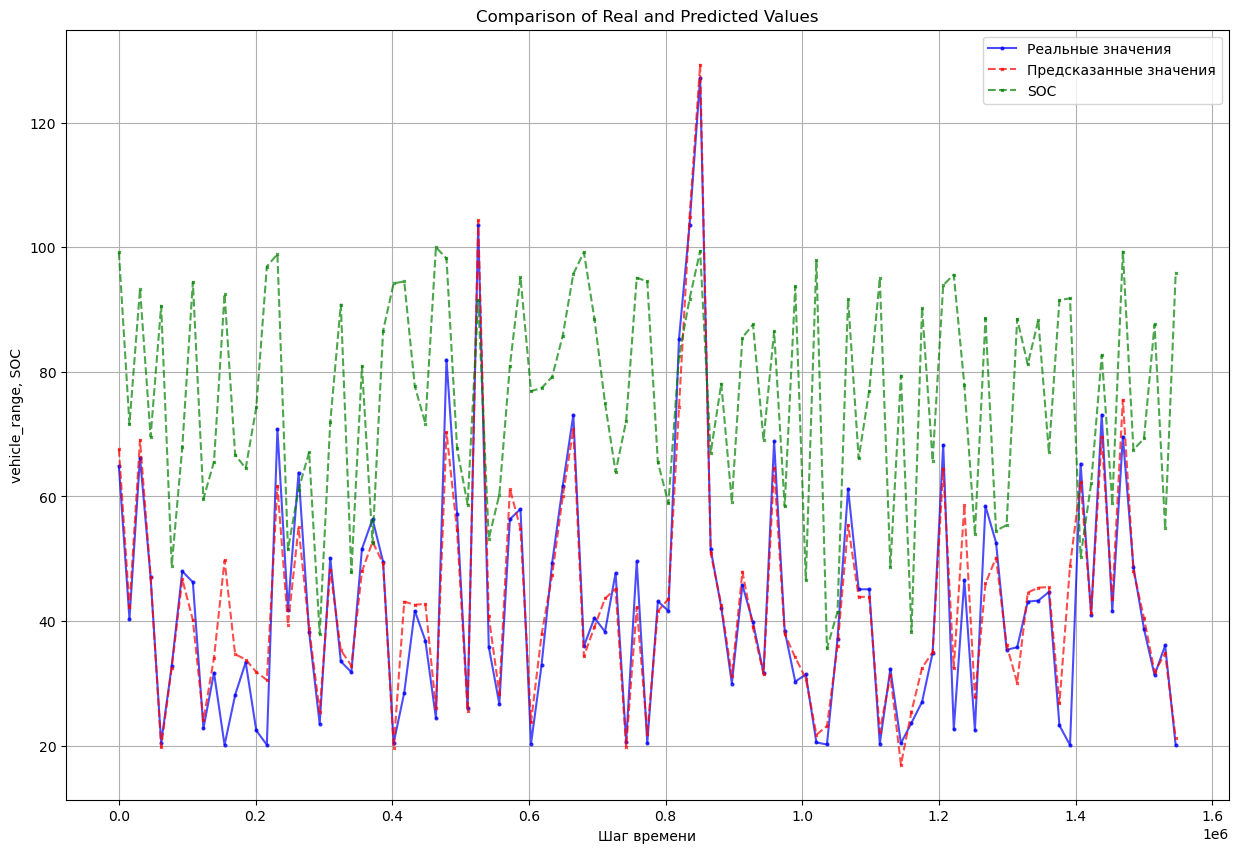

In [80]:
Visualizer.plot_resultsXGB(result_df["y"], result_df["yhat"], result_df["SOC"]) #1 С

In [63]:
Visualizer.plot_resultsXGB(result_df["y"], result_df["yhat"]) #100 млС

In [ ]:
Сохранение и загрузка модели:

In [82]:
model_train.save_model('D:/vehicle_range_nn/NN_model_python/xgboost_model.json') #сохранение

In [ ]:
xgb_load = xgb.Booster()
xgb_load.load_model('D:/vehicle_range_nn/NN_model_python/xgboost_model.json') #загрузка

In [ ]:
Cоздание и обучение LSTM модели:

In [ ]:

class LSTMModel:
    def __init__(self, time_steps, input_shape):
        self.model = Sequential()
        self.model.add(Input(shape=input_shape))
        self.model.add(LSTM(50, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, X_train, y_train, epochs=120, batch_size=100, validation_split=0.2):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[early_stopping])

    def predict_future(self, input_data, steps, input_shape):
        predictions = []
        current_input = input_data
        for _ in range(steps):
            pred = self.model.predict(current_input.reshape(1, *input_shape))[0]
            predictions.append(pred[0])

            pred_expanded = np.zeros((1, input_shape[1]))
            pred_expanded[0, 0] = pred  # Place the prediction in the first column if it's the target parameter

            current_input = np.append(current_input[1:], pred_expanded, axis=0)

        return predictions

    def save_model(self, file_path):
        self.model.save(file_path)
        

        

In [ ]:
preprocessor = DataPreprocessor(df, features, target)
X_scaled, y = preprocessor.prepare_dataLSTM()
time_steps = 10
X_train, y_train = preprocessor.create_dataset(X_scaled, y, time_steps)
lstm_model = LSTMModel(time_steps, (X_train.shape[1], X_train.shape[2]))
lstm_model.train(X_train, y_train)
lstm_model.save_model('D:/vehicle_range_nn/NN_model_python/my_model.keras')

In [ ]:
Тестирование XGB:

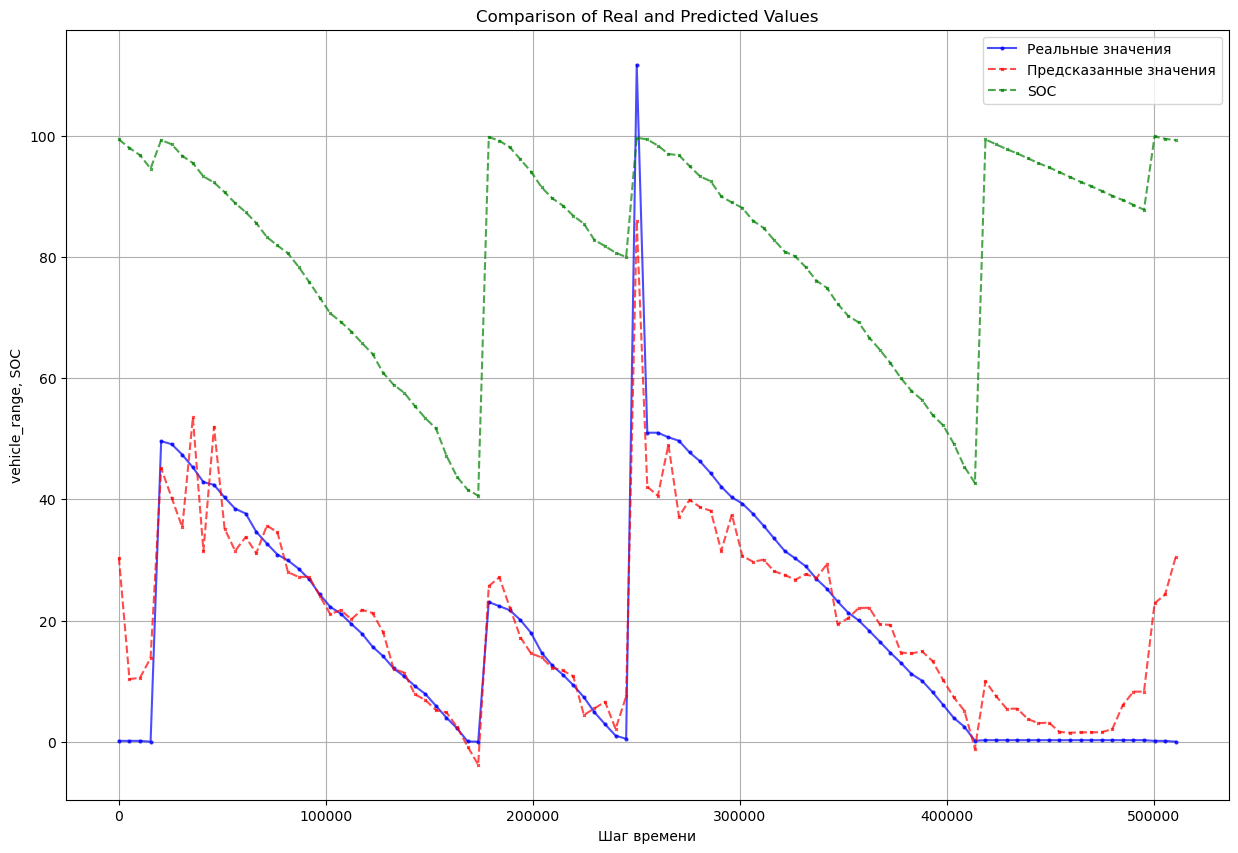

In [96]:
#загрузка данных
folder_path = 'D:/vehicle_range_nn/logs/test_logs/test_handler_final/pythonData.mat'
processor = MatFileProcessor(folder_path)
df = processor.process_all_files()
test_df = df

features = ['B2V_SOC', 'B2V_TotalI', 'LocalHourOffset', 'LocalMinuteOffset',
            'Year', 'Day', 'Month', 'Hours', 'Minutes', 'Seconds',
            'Total_system_power', 'outside_temperature', 'L_INV2TM_MotorSpeed','R_INV2TM_MotorSpeed','avg_B2V_SOC',
            'avg_B2V_TotalI','avg_L_INV2TM_MotorSpeed']
target = 'vehicle_range'
preprocessor = DataPreprocessor(test_df, features, target)
x_test, y_test = preprocessor.prepare_dataXGB()
dtest = xgb.DMatrix(x_test)
y_pred = model_train.predict(dtest)
# Создаем датасет для предсказанных и реальных значений
result_df = pd.DataFrame({
    "y": y_test,
    "yhat": y_pred,
    "SOC": x_test.B2V_SOC
})
Visualizer.plot_resultsXGB(result_df["y"], result_df["yhat"], result_df["SOC"]) #1 С

In [94]:
result_df["SOC"]

0         86.4
1         86.4
2         86.4
3         86.4
4         86.4
          ... 
106907    68.9
106908    68.9
106909    68.9
106910    68.9
106911    68.9
Name: SOC, Length: 106912, dtype: float64